
Model training with training data generated on the fly
=======================================================

Depending on the concrete usecase, data generation speed with AcouPipe can be fast enough to directly incorporate the generated data for model training without the need of intermediate file saving.

This example demonstrates how to **generate training data on the fly** for the most simple **supervised source localization** tasks.

Here, the example demonstrates **single source localization** model training similar to [KHS19], but without predicting the source strength. 
For demonstration, the **Beamforming map** is created with calculation `mode="wishart"` (no time data is simulated).

To prevent thread overloading due to parallel data generation, the number of parallel numba threads was limited by exporting the variable `export NUMBA_NUM_THREADS=1` before running the script.


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import multiprocessing
import numba
import tensorflow as tf
import ray
ray.shutdown() # shutdown existing tasks
ray.init(log_to_driver=False) # start a ray server (without logging the details for clean documentation)
physical_devices = tf.config.list_physical_devices('GPU')

print("Num GPUs:", len(physical_devices))
print("Num CPUs:", multiprocessing.cpu_count())
print("Numba number of concurrent threads:", numba.config.NUMBA_NUM_THREADS)

2023-11-14 14:28:06,089	INFO worker.py:1673 -- Started a local Ray instance.


Num GPUs: 1
Num CPUs: 48
Numba number of concurrent threads: 1


## Build the dataset generator

At first, we manipulate the dataset config to only create single source examples on a coarser grid of size $32 \times 32$

In [2]:
import numpy as np
from acoupipe.datasets.synthetic import DatasetSynthetic

# create dataset (calculated on a GPU Workstation with several cpus)
dataset = DatasetSynthetic(max_nsources=1, tasks=multiprocessing.cpu_count(), mode='wishart')       

# we manipulate the grid to have a coarser resolution 
dataset.config.grid.increment = 1/31 # 32 x 32 grid

# build TensorFlow datasets for training and validation
training_dataset = dataset.get_tf_dataset(
    features=["sourcemap","loc"], f=1000, split="training",size=100000000) # quasi infinite
validation_dataset = dataset.get_tf_dataset(
    features=["sourcemap","loc"], f=1000, split="validation",size=100)

/usr/local/lib/python3.8/dist-packages/acoupipe/datasets/features.py:104: Warning: Queried frequency (1000 Hz) not in set of discrete FFT sample frequencies. Using frequency 1071.88 Hz instead.
  fidx = [get_frequency_index_range(


The TensorFlow dataset API can be used to build a data pipeline from the data generator. Here, batches with 16 source cases are used. We use the `prefetch` method to generate data when during training steps on the GPU, where the CPUs are usually idle. For the validation_dataset, the `cache` method prevents recalculation of the validation data

In [3]:
import tensorflow as tf 

def yield_features_and_labels(data):   
    feature = data['sourcemap'][0]
    f_max = tf.reduce_max(feature)
    feature /= f_max
    label = data['loc'][:2]
    return (feature,label)

training_dataset = training_dataset.map(yield_features_and_labels).batch(16).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(yield_features_and_labels).batch(16).cache()


## Train the model

Now, one can build the ResNet50V2 model and use the data to fit the model. This may take up to a few hours, depending on the computational infrastructure. 

In [4]:
# build model architecture
model = tf.keras.Sequential(
    tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights=None,
    input_shape=(32,32,1),
    ))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2, activation=None))

# compile and fit
model.compile(optimizer=tf.optimizers.Adam(),loss='mse')
model.fit(training_dataset,validation_data=validation_dataset, epochs=5,steps_per_epoch=10000, verbose=2)

Epoch 1/5
10000/10000 - 493s - loss: 0.0167 - val_loss: 0.7074 - 493s/epoch - 49ms/step
Epoch 2/5
10000/10000 - 443s - loss: 0.0062 - val_loss: 0.0046 - 443s/epoch - 44ms/step
Epoch 3/5
10000/10000 - 443s - loss: 0.0042 - val_loss: 0.0403 - 443s/epoch - 44ms/step
Epoch 4/5
10000/10000 - 433s - loss: 0.0019 - val_loss: 0.0104 - 433s/epoch - 43ms/step
Epoch 5/5
10000/10000 - 432s - loss: 0.0011 - val_loss: 0.0133 - 432s/epoch - 43ms/step


After successfully training, the model can be used for source localization.

In [9]:
dataset.tasks=1
test_dataset = dataset.get_tf_dataset(
    features=["sourcemap","loc"], f=1000, split="validation",size=1, start_idx=2) 
test_dataset = test_dataset.map(yield_features_and_labels).batch(1)
sourcemap, labels = next(iter(test_dataset))

prediction = model.predict(sourcemap)[0]
print(prediction)

sourcemap = sourcemap.numpy().squeeze()


1/1 [==============================] - 0s 40ms/step
[ 0.23072581 -0.0644986 ]


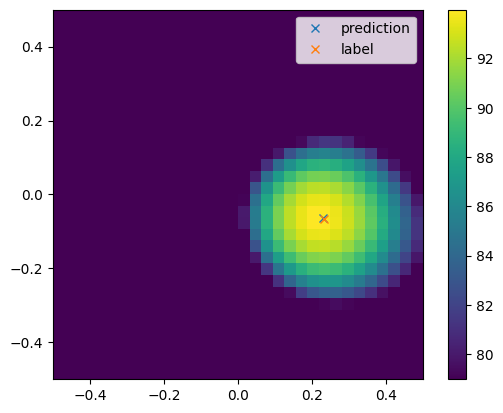

In [10]:
import matplotlib.pyplot as plt
from acoular import L_p

extent = dataset.config.grid.extend() 
loc = labels[0]

plt.figure()
plt.imshow(L_p(sourcemap).T,
            vmax=L_p(sourcemap.max()),
            vmin=L_p(sourcemap.max())-15,
            extent=extent,
            origin="lower")
plt.plot(prediction[0],prediction[1],'x',label="prediction")
plt.plot(loc[0],loc[1],'x',label="label")
plt.colorbar()
plt.legend()
plt.show()